In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT')

In [3]:
h36m_3d_world, h36m_cam_param = load_h36m()

==> Loading 3D data wrt World CS...


In [4]:
load_folder = '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl'
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl_canonical_3d_same_dist'
if not os.path.exists(save_folder): os.makedirs(save_folder)

In [61]:
for item in glob(load_folder + '/*.pkl'):
    save_path = item.replace('h36m_gt_pkl', 'h36m_gt_pkl_canonical_3d_same_dist')
    if os.path.exists(save_path): 
        print('already exists', save_path)
        continue
    data = readpkl(item)
    
    cam_param = data['cam_param'][0].reshape(1)[0].copy()
    int_mat = cam_param['intrinsic']
    ext_mat = cam_param['extrinsic']
    cam_proj = int_mat @ ext_mat
    R = ext_mat[:3, :3]
    t = ext_mat[:3, 3]
    C = T_to_C(R, t)
    num_frames = len(data['world_3d'])
    world_3d = np.array(data['world_3d']).copy() # (F, J, 3)
    canonical_3d = get_canonical_3d(world_3d, world_3d, C, R, canonical_type='same_dist')

    fx, fy, cx, cy = int_mat[0, 0], int_mat[1, 1], int_mat[0, 2], int_mat[1, 2]
    for frame_num in tqdm(range(num_frames)):
        # world to camera
        pos = canonical_3d[frame_num].copy()
        cam_3d = World2CameraCoordinate(pos, cam_param['extrinsic']) * 1000 # World coordinate -> Camera coordinate
        cam_3d_hat = get_rootrel_pose(cam_3d)
        
        # camera to image
        box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
        img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
        img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose  
        
        # 2.5d factor
        pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat) # x,y,z 사용
        
        # joint 2.5d image
        img_25d = img_3d * pred_lambda
    
        # store
        data['joint_2d_from_canonical_3d'][frame_num] = np.array(img_2d).copy()
        data['joint3d_image_from_canonical_3d'][frame_num] = np.array(img_3d).copy()
        data['joints_2.5d_image_from_canonical_3d'][frame_num] = np.array(img_25d).copy()
        data['2.5d_factor_from_canonical_3d'][frame_num] = np.array(pred_lambda).copy()
        data['canonical_3d'][frame_num] = np.array(canonical_3d[frame_num]).copy()
        #break
    savepkl(data, save_path)
    #break

already exists /home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl_canonical_3d_same_dist/S1_54138969_Walking.pkl


 30%|██▉       | 1458/4870 [00:20<00:48, 70.80it/s] 


KeyboardInterrupt: 

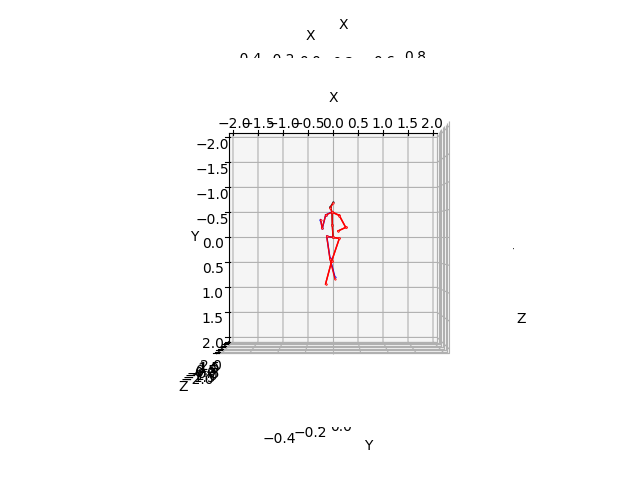

In [50]:
%matplotlib widget
fig = plt.figure(0)
ax = axes_3d(fig, view=(-90,-90))
draw_3d_pose(ax, img_3d_hat*pred_lambda/1000)
draw_3d_pose(ax, cam_3d_hat/1000, color='r')
plt.show()

### change key name: add '_from_canonical_3d'

In [18]:
for item in tqdm(glob(save_folder + '/*.pkl')):
    #print(item)
    data = readpkl(item)
    #print(data.keys())
    if 'joint_2d' in data.keys():
        del data['joint_2d']
    # else:
    #     print('no joint_2d')
    if 'joint3d_image' in data.keys():
        data['joint3d_image_from_canonical_3d'] = data['joint3d_image'].copy()
        del data['joint3d_image']
    # else: 
    #     print('no joint3d_image')
    if 'joints_2.5d_image' in data.keys():
        data['joints_2.5d_image_from_canonical_3d'] = data['joints_2.5d_image'].copy()
        del data['joints_2.5d_image']
    # else:
    #     print('no joints_2.5d_image')
    if '2.5d_factor' in data.keys():
        data['2.5d_factor_from_canonical_3d'] = data['2.5d_factor'].copy()
        del data['2.5d_factor']
    # else:
    #     print('no 2.5d_factor')
    #print(data.keys())
    savepkl(data, item)
    #break

100%|██████████| 836/836 [05:17<00:00,  2.63it/s]
